In [20]:
import tensorflow.keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix,roc_auc_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_dir = 'archive/Training/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)

#print(train_paths[0])
len(train_paths)

5712

In [3]:
test_dir = 'archive/Testing/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)

#print(trest_paths[0])
len(test_paths)

1311

In [4]:
train_data = []
train_labels = []

test_data = []
test_labels = []

for imagePath in train_paths:
    # extract the class label
    label = imagePath.split('/')[-2]
    
    # load the image 
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = np.array(image)/255.0
    
    # update training data
    train_data.append(image)
    train_labels.append(label)

for imagePath in test_paths:
    # extract the class label
    label = imagePath.split('/')[-2]
    
    # load the image 
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = np.array(image)/255.0
    
    # update testing data
    test_data.append(image)
    test_labels.append(label)
    

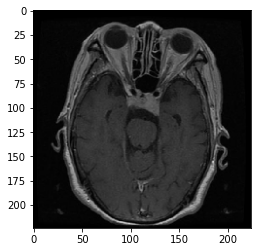

In [5]:
plt.imshow(train_data[0])

In [6]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)
  labels_to_index=dict(zip(le.classes_, le.transform(le.classes_)))
  labels = to_categorical(labels)
  return  data,labels,labels_to_index

In [7]:
train_data,train_labels,labels_to_index = convert_data_labels(train_data,train_labels)
test_data,test_labels,labels_to_index= convert_data_labels(test_data,test_labels)

In [8]:
labels_to_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [9]:
index_to_labels={}
for label,value in enumerate(labels_to_index):
    index_to_labels[label]=value

In [10]:
index_to_labels

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [11]:
resnet_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Set all layers to non-trainable
for layer in resnet_model.layers[:171]:
    layer.trainable = False

for layer in resnet_model.layers[171:]:
    layer.trainable = True

In [12]:
model = Sequential([
    Input(shape=(224,224,3)),
    resnet_model,
    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax'), # num labels = 4
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,433,412
Trainable params: 13,900,420
No

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

In [14]:
BS=32

# train datagen
train_datagen = ImageDataGenerator(
#                   rescale = 1/255,
                  validation_split=0.25
)


# test datagen
test_datagen = ImageDataGenerator(
#                     rescale = 1/255
    
)

train_gen = train_datagen.flow(train_data, train_labels, batch_size=BS,subset="training")

val_gen = train_datagen.flow(train_data, train_labels, batch_size=BS,subset="validation")

test_gen = train_datagen.flow(test_data, test_labels, batch_size=BS)

In [15]:
#training
history=model.fit(train_gen, 
          epochs=15,
          validation_data=val_gen
         )

Epoch 1/15
134/134 [==============================] - 451s 3s/step - loss: 0.9507 - accuracy: 0.6277 - auc: 0.8574 - val_loss: 1.0116 - val_accuracy: 0.6576 - val_auc: 0.8529
Epoch 2/15
134/134 [==============================] - 453s 3s/step - loss: 0.6282 - accuracy: 0.7488 - auc: 0.9319 - val_loss: 0.6987 - val_accuracy: 0.7283 - val_auc: 0.9188
Epoch 3/15
134/134 [==============================] - 410s 3s/step - loss: 0.5205 - accuracy: 0.7930 - auc: 0.9523 - val_loss: 0.4951 - val_accuracy: 0.8312 - val_auc: 0.9629
Epoch 4/15
134/134 [==============================] - 398s 3s/step - loss: 0.4940 - accuracy: 0.7993 - auc: 0.9567 - val_loss: 0.5164 - val_accuracy: 0.7941 - val_auc: 0.9544
Epoch 5/15
134/134 [==============================] - 398s 3s/step - loss: 0.4618 - accuracy: 0.8184 - auc: 0.9623 - val_loss: 0.4219 - val_accuracy: 0.8368 - val_auc: 0.9693
Epoch 6/15
134/134 [==============================] - 399s 3s/step - loss: 0.4119 - accuracy: 0.8347 - auc: 0.9695 - val_loss

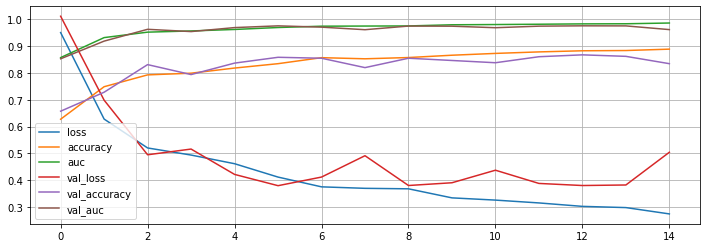

In [16]:
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

In [17]:
#Per valutare il modello appresso sul test set utilizziamo il metodo evaluate.
model.evaluate(test_gen)

41/41 [==============================] - 87s 2s/step - loss: 0.5772 - accuracy: 0.8070 - auc: 0.9520


[0.5772411227226257, 0.8070175647735596, 0.9519547820091248]

In [18]:
#Mediante il metodo predict eseguiamo una predizione circa una nuova istanza.
test_pred=model.predict(test_gen)
test_pred

array([[4.0025132e-12, 1.5297582e-08, 1.0000000e+00, 1.3512192e-13],
       [1.4264245e-12, 1.1226112e-03, 9.9887735e-01, 6.5368974e-11],
       [1.1675198e-01, 8.8203722e-01, 1.1253494e-03, 8.5494132e-05],
       ...,
       [3.4334615e-04, 2.5920662e-01, 1.7566949e-02, 7.2288305e-01],
       [6.5370132e-17, 9.9812680e-01, 1.8731724e-03, 4.0066936e-11],
       [2.4069170e-02, 9.7481120e-01, 1.1052195e-03, 1.4447768e-05]],
      dtype=float32)

In [21]:
#finding the class by np.argmax() from each prediction
test_pred_class=[]
test_labels_class=[]
for i,pred in enumerate(test_pred):
    test_pred_class.append(np.int(np.argmax(pred)))
    
for i,pred in enumerate(test_labels):
    test_labels_class.append(np.int(np.argmax(pred)))

In [24]:
# print(test_pred_class)
# print(test_labels_class)

In [37]:
#confusion matrix
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes,normalize=True,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Normalized confusion matrix


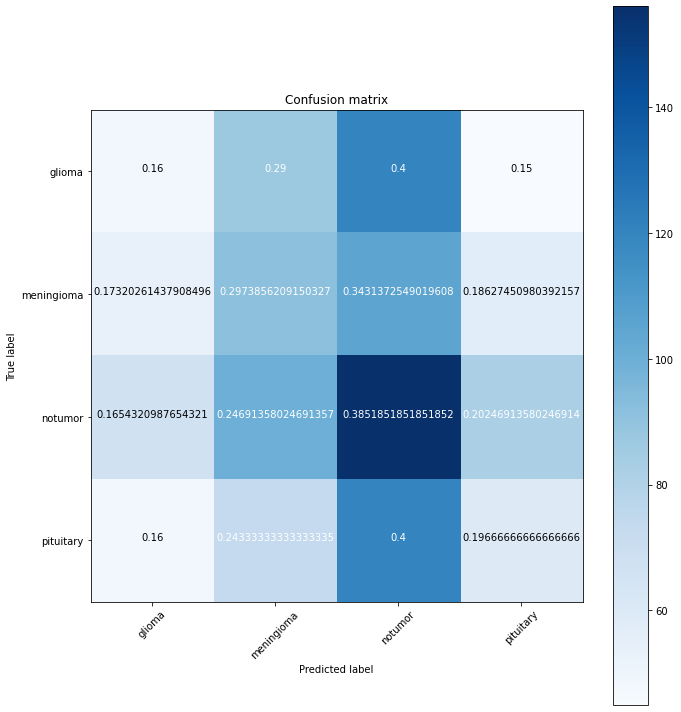

In [38]:
cm = confusion_matrix(test_labels_class, test_pred_class)
labels=list(index_to_labels.values())
plot_confusion_matrix(cm,labels)

In [39]:
roc_auc_score(test_labels,test_pred)

0.5005551555493771

In [40]:
path_to_label={}
for i,path in enumerate(test_paths):
    label = path.split('/')[-2]
    path_to_label[path]=label

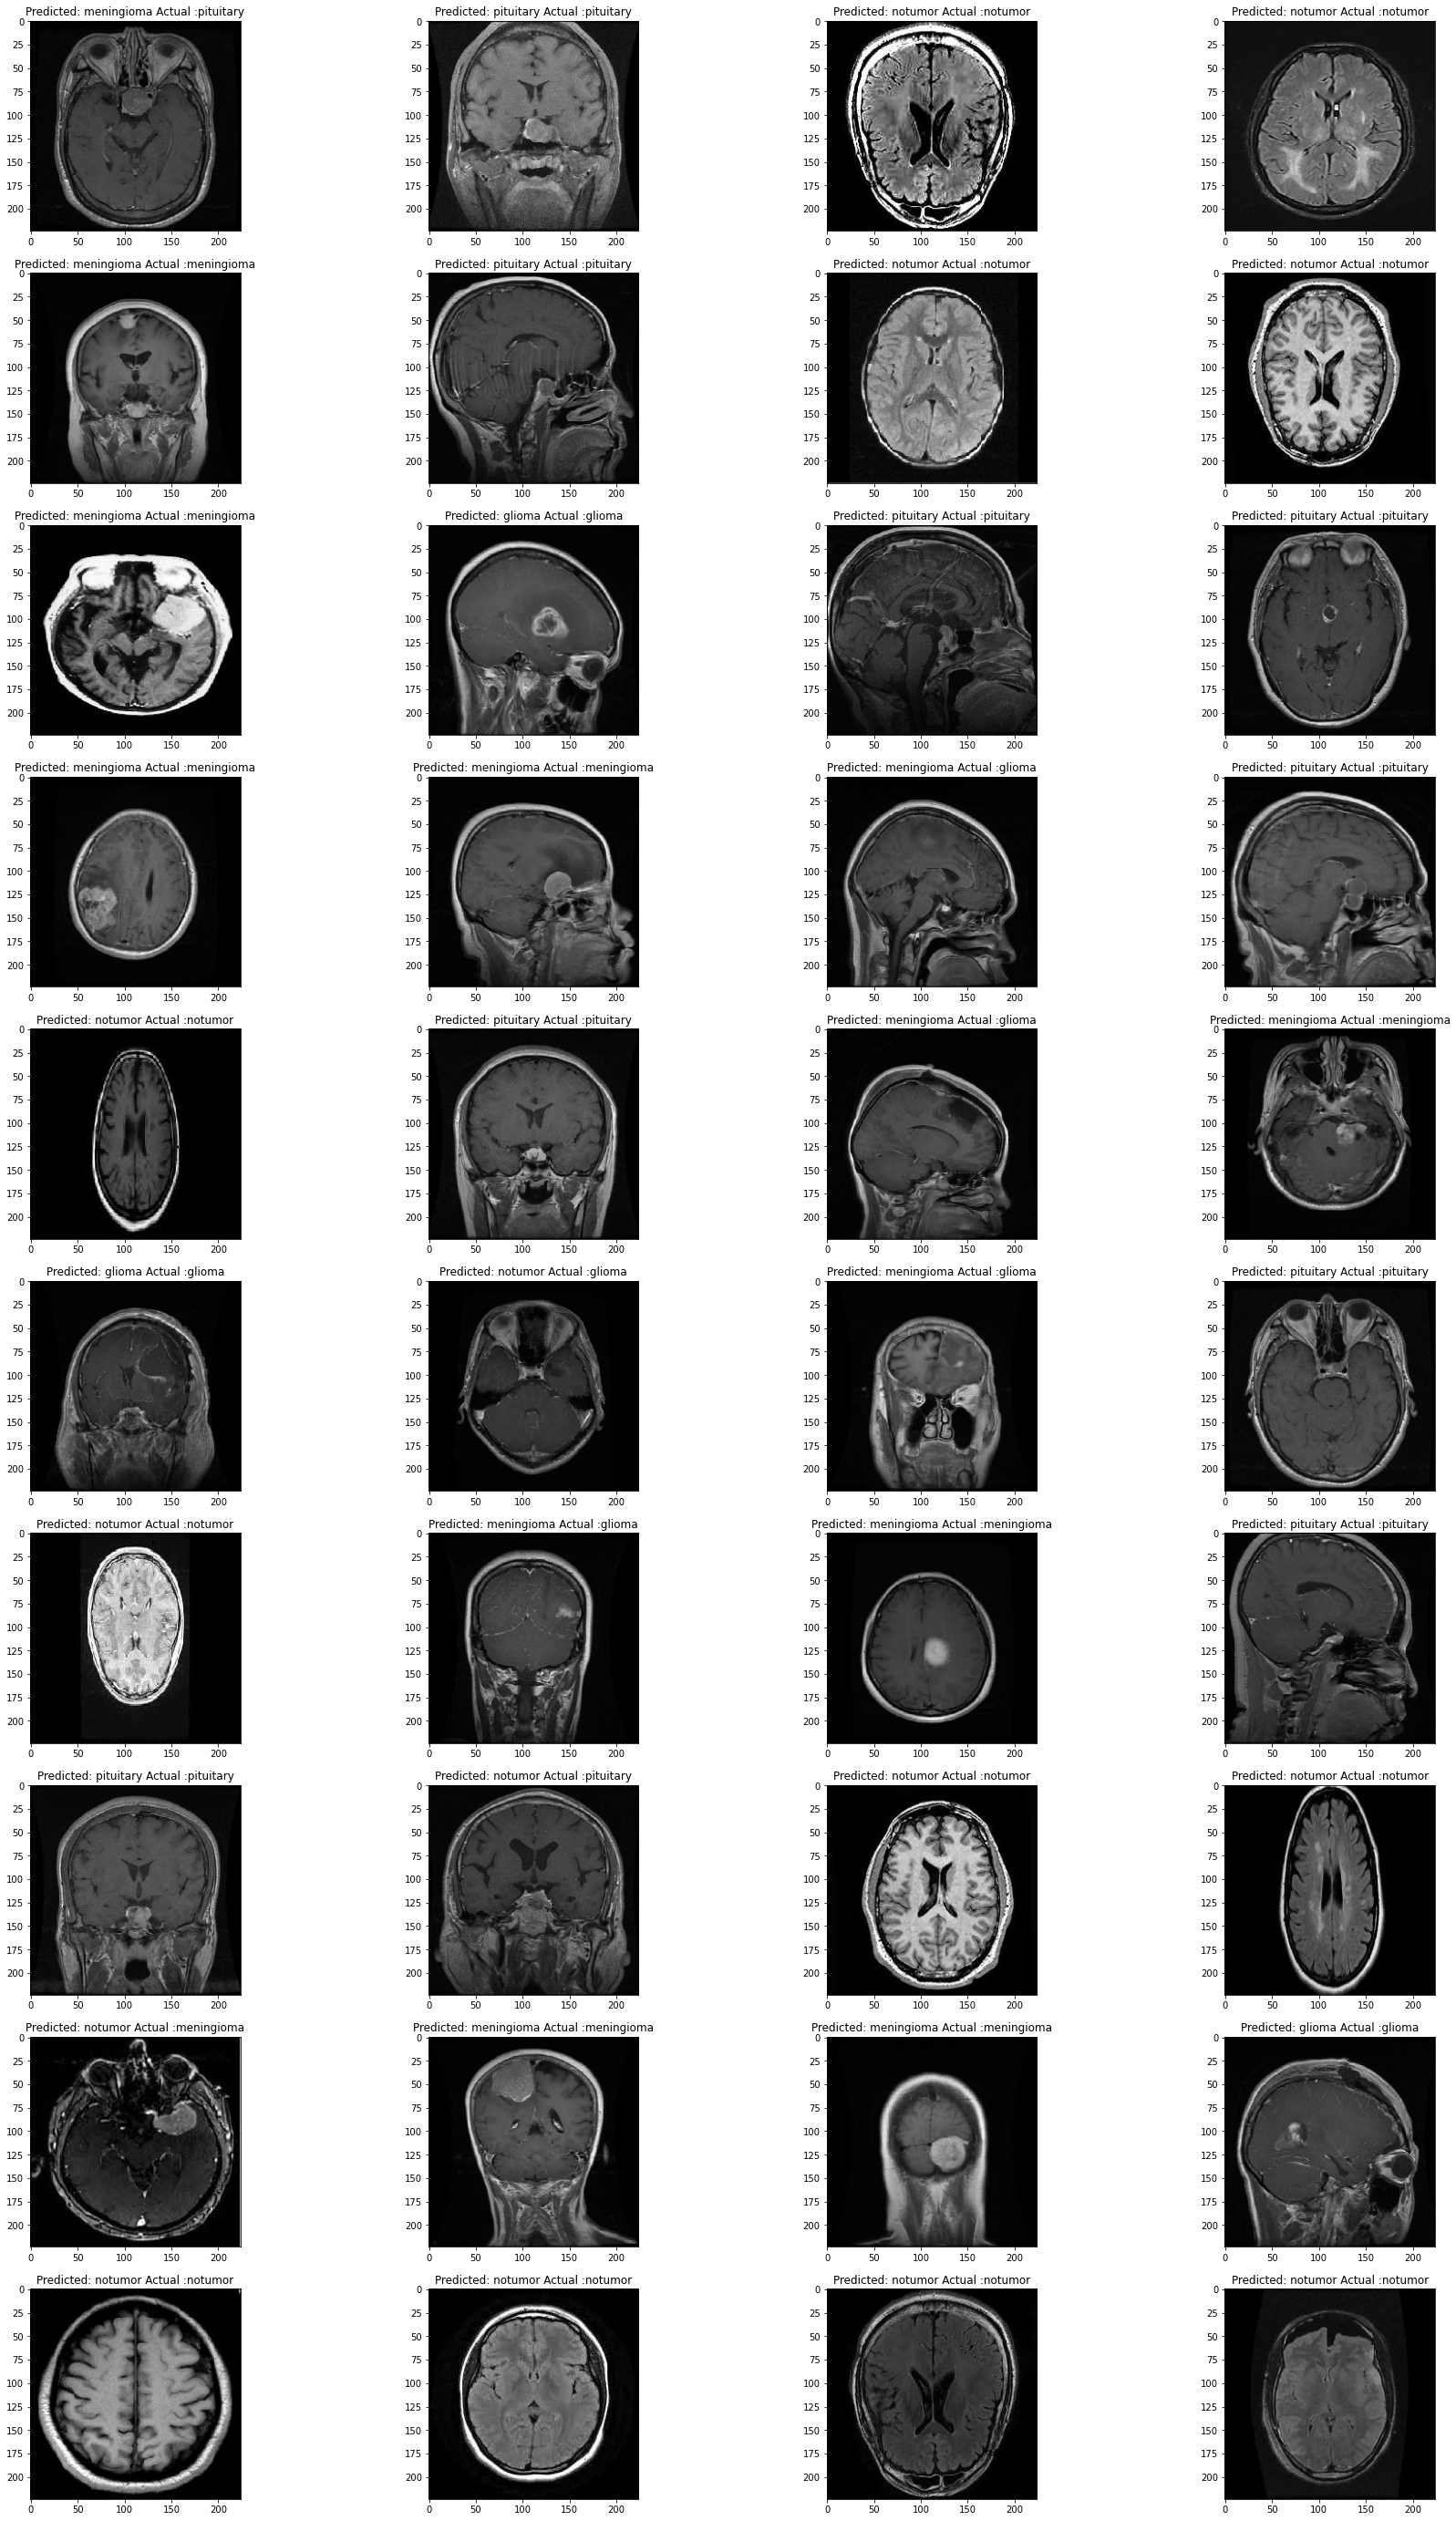

In [44]:
#Model Prediction
from PIL import Image

predictions=model.predict(test_gen)
fig = plt.figure(figsize=(30, 50))
columns = 4
rows = 10
for i in range(1, columns*rows +1):
    img = load_img(test_paths[i], target_size=(224, 224))
    img = img_to_array(img)
    img = np.array(img)/255.0
    img=np.reshape(img,(-1,224,224,3))
    pred=model.predict(img)
    index=np.argmax(pred)
    klass=index_to_labels[index] 
    actual=path_to_label[test_paths[i]]
    img=np.reshape(img,(224,224,3))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'Predicted: { klass} Actual :{actual}')
plt.show()